**Prepared Dataset and The Other Stuffs**
---
Menyiapkan dataset dan semua library yang dibutuhkan

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import io
import itertools
from google.colab import drive
import seaborn as sns

%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
print(tf.__version__)
print(tfds.__version__)

2.12.0
4.9.2


In [9]:
drive.mount('/content/drive')
DATASET_DIR = '/content/drive/MyDrive/DATASETS'
BATCH_SIZE = 32
IMG_HEIGHT = 300
IMG_WIDTH = 300
SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Split to Train, Test, Val and Preprocessed Dataset***
---
Dataset di split ke dalam train test dan val, dengan rasio 0.8, 0.1, 0.1 . 
Juga dilakukan shuffle, augmentasi, dan lain lain.

In [10]:
# Make Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=345,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE
)

# Make Val Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=345,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE
)

# Make Test Dataset
val_batches = tf.data.experimental.cardinality(dataset=val_ds)
test_ds = val_ds.take((1 * val_batches) // 2)
val_ds = val_ds.skip((1 * val_batches) // 2)

print('\nSPLITTING VALIDATION FOR TESTING:')
print(f'Using {tf.data.experimental.cardinality(dataset=val_ds) * BATCH_SIZE} files for validation')
print(f'Using {tf.data.experimental.cardinality(dataset=test_ds) * BATCH_SIZE} files for testing')


Found 8887 files belonging to 13 classes.
Using 7110 files for training.
Found 8887 files belonging to 13 classes.
Using 1777 files for validation.

SPLITTING VALIDATION FOR TESTING:
Using 896 files for validation
Using 896 files for testing


['Jagung_Bercak_Daun', 'Jagung_Hawar_Daun', 'Jagung_Karat_Daun', 'Jagung_Sehat', 'Kentang_Bercak_Kering', 'Kentang_Busuk_Daun', 'Kentang_Sehat', 'Kentang_Virus', 'Padi_Bercak_Cokelat', 'Padi_Blast', 'Padi_Hawar_Daun', 'Padi_Hispa', 'Padi_Sehat']


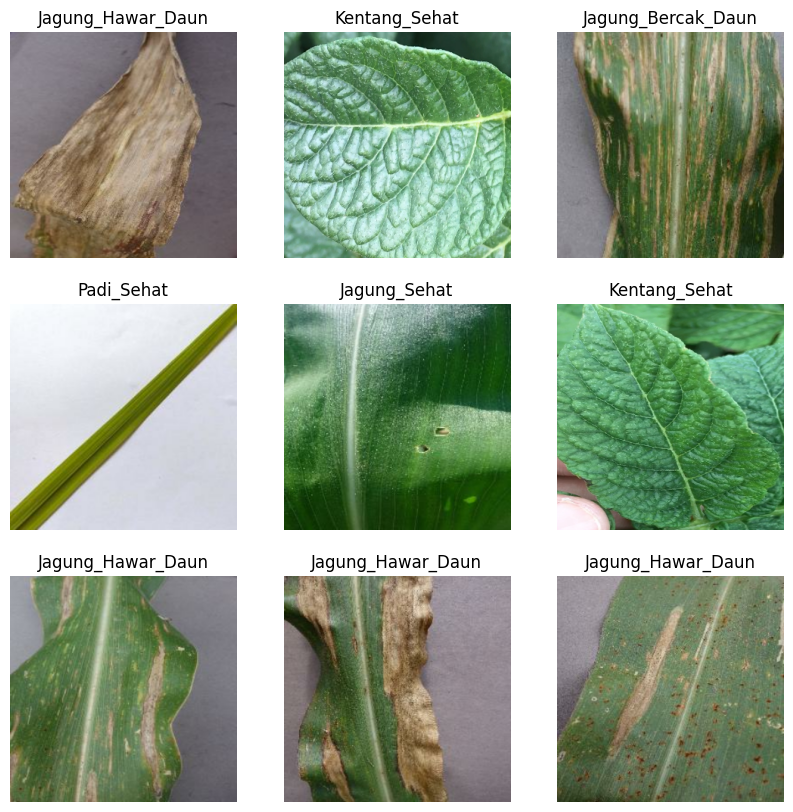

In [11]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'), 
  tf.keras.layers.RandomRotation(factor=0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomBrightness(factor=[-0.3,0.3]),
  tf.keras.layers.RandomContrast(factor=0.2)
])

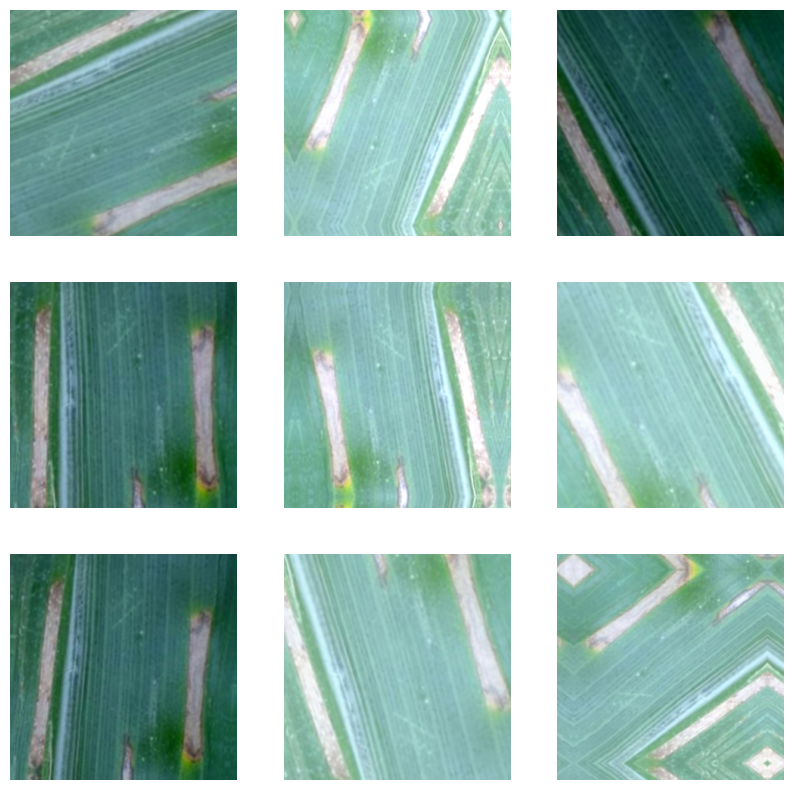

In [13]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [14]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

***Create a Callback Function***
---
Membuat fungsi callback yang diperlukan

In [15]:
class myCallback(keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.97:                 
                print("\nReached 98% accuracy so cancelling training!")
                
                # Stop training once the above condition is met
                self.model.stop_training = True

stop_callback = myCallback()

***Model Architecture***
---
Membuat model dengan transfer learning dan layers tambahan

In [16]:
base_model = tf.keras.applications.EfficientNetB3(input_shape=(300,300,3), include_top=False, weights='imagenet')
base_model.trainable = True

43941136/43941136 [==============================] - 0s 0us/step


In [17]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  385


In [18]:
# Fine-tune from this layer onwards
layer_tune = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:layer_tune]:
  layer.trainable = False

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    data_augmentation,
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(13, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          442400    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                  

In [21]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [22]:
history_ft = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, 
                    callbacks=[stop_callback])

Epoch 1/50
223/223 [==============================] - 602s 2s/step - loss: 1.3097 - accuracy: 0.5636 - val_loss: 0.4684 - val_accuracy: 0.8411
Epoch 2/50
223/223 [==============================] - 106s 475ms/step - loss: 0.5339 - accuracy: 0.8269 - val_loss: 0.3373 - val_accuracy: 0.8922
Epoch 3/50
223/223 [==============================] - 106s 474ms/step - loss: 0.3884 - accuracy: 0.8734 - val_loss: 0.3124 - val_accuracy: 0.9126
Epoch 4/50
223/223 [==============================] - 106s 474ms/step - loss: 0.3191 - accuracy: 0.8941 - val_loss: 0.2585 - val_accuracy: 0.9171
Epoch 5/50
223/223 [==============================] - 106s 474ms/step - loss: 0.2766 - accuracy: 0.9056 - val_loss: 0.2430 - val_accuracy: 0.9296
Epoch 6/50
223/223 [==============================] - 106s 474ms/step - loss: 0.2554 - accuracy: 0.9160 - val_loss: 0.2724 - val_accuracy: 0.9194
Epoch 7/50
223/223 [==============================] - 106s 474ms/step - loss: 0.2230 - accuracy: 0.9228 - val_loss: 0.2315 - va

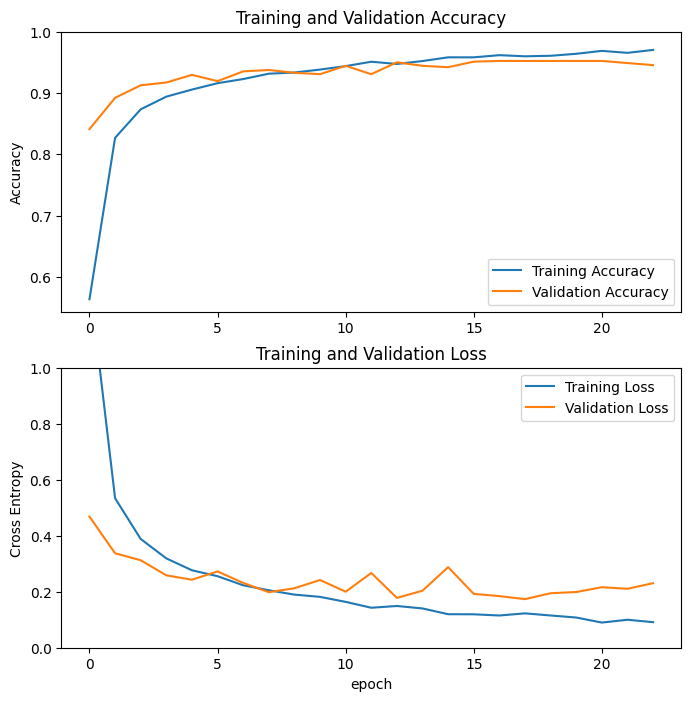

In [23]:
acc = history_ft.history['accuracy']
val_acc = history_ft.history['val_accuracy']

loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

***Testing Model***
---
Cek akurasi model dengan data test yang sudah dibuat

In [24]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

28/28 [==============================] - 7s 201ms/step - loss: 0.2523 - accuracy: 0.9442
Test accuracy : 0.9441964030265808


In [25]:
test_data = list(test_ds)
features = np.concatenate([test_data[n][0] for n in range(0, len(test_data))])
targets = np.concatenate([test_data[n][1] for n in range(0, len(test_data))])

In [26]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [27]:
predictions = probability_model.predict(features)

28/28 [==============================] - 9s 187ms/step


Predictions:
 [[0.06794272 0.18468744 0.06794272 ... 0.06794272 0.06794272 0.06794272]
 [0.06794769 0.06794758 0.06794871 ... 0.06794808 0.06794872 0.06794847]
 [0.06794272 0.06794272 0.06794272 ... 0.06794272 0.06794272 0.06794272]
 ...
 [0.06966747 0.06962903 0.06972796 ... 0.06982987 0.07178365 0.06976373]
 [0.06794904 0.06794822 0.06794833 ... 0.06794851 0.06794865 0.06794826]
 [0.0679428  0.06794281 0.06794342 ... 0.18468578 0.06794279 0.06794279]]
Labels:
 [ 1  7  5  2 11  5  3  1  2  2  8  3  2  3  8  1  0  2  0  6  4 12 11  1
  3 11  1  1  9 12  9  6  6  0 10  1  6  2 10  7  5  6  8  6  2 10 10  5
  3  1  1  8  8  4  2  5  9  2  1  2  6  3  9  9  8  6  1  3  3  9  0  3
  1  3  1  3 12  1  0  2 12 12  9  1  4  6  2  3  1  2 10  4  1  8  2  6
  0 10 10 10  6  6  2  1  8 12  6  3 12  6  6  2  8 10  1  9  1  0 10  1
  1 11  0  8  3  0  0  1  1  0  6  3  2  7  9  0 12  0  2 12  1  6  0 11
  1  8  2  1  1  9  8  2  7 10 12  0  4  4  0  1 11  4  1  4  3  0  3  4
  7  2  1  8  2  3  2 

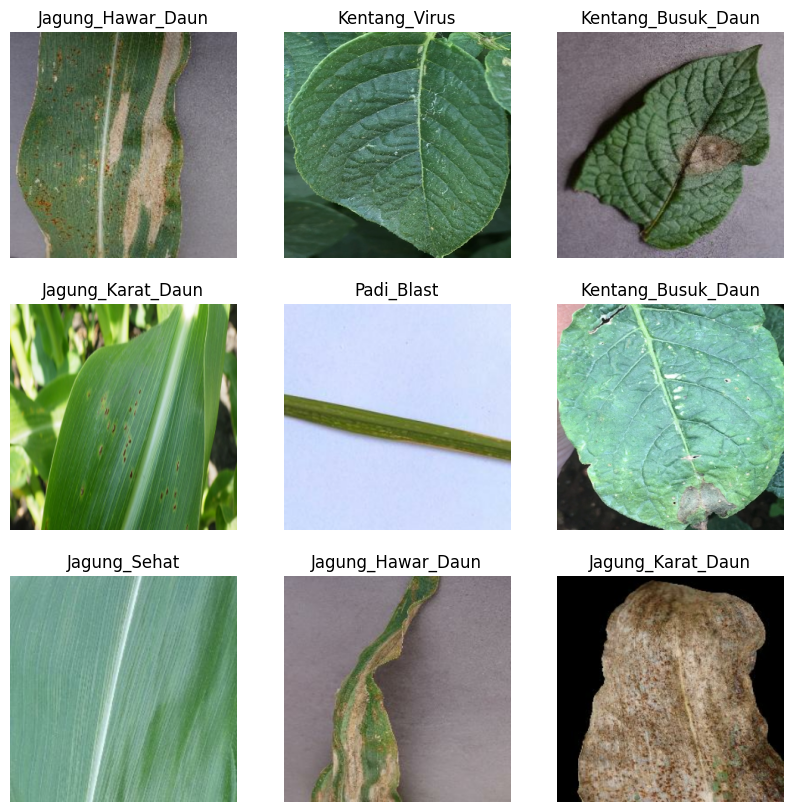

In [28]:
print('Predictions:\n', predictions)
print('Labels:\n', targets)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(features[i].astype("uint8"))
 
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

***Monitoring Akurasi***
---
Membuat Confusion Materix dan Classification Report

###Confusion Matrix

In [29]:
y_true = targets
y_pred = np.argmax(predictions, axis=-1)

In [31]:
conf_mat = confusion_matrix(y_true, y_pred)

In [32]:
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize = (12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    print(cm)
    print()
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
conf_mat_labels = class_names

[[ 62   7   0   0   0   0   0   0   0   0   0   0   0]
 [ 10 107   0   0   0   0   0   0   0   0   0   0   0]
 [  2   2 130   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0 109   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  48   0   1   1   0   0   0   0   0]
 [  0   0   0   0   0  41   1   1   0   0   0   0   0]
 [  0   0   0   0   0   0  50   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0  40   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  57   2   0   3   2]
 [  0   0   0   0   0   0   0   0   1  52   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0  60   0   0]
 [  0   0   0   0   0   0   0   0   1   4   0  37   7]
 [  0   0   0   0   0   0   0   0   0   0   0   2  53]]



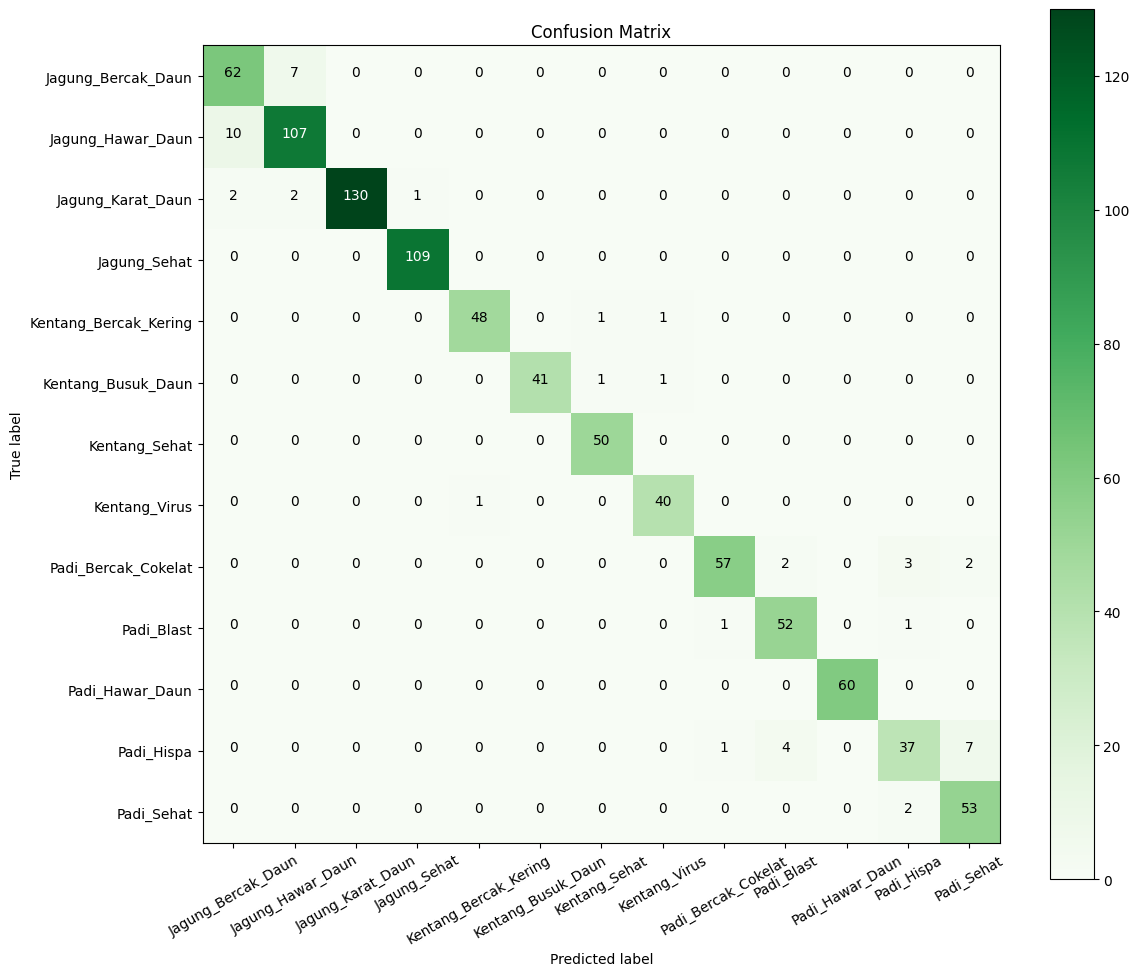

In [34]:
show_confusion_matrix(cm=conf_mat, classes=conf_mat_labels, title='Confusion Matrix')

###Classification Report

---

Akurasi, presisi, recall, f-1 score

In [35]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

   Jagung_Bercak_Daun       0.84      0.90      0.87        69
    Jagung_Hawar_Daun       0.92      0.91      0.92       117
    Jagung_Karat_Daun       1.00      0.96      0.98       135
         Jagung_Sehat       0.99      1.00      1.00       109
Kentang_Bercak_Kering       0.98      0.96      0.97        50
   Kentang_Busuk_Daun       1.00      0.95      0.98        43
        Kentang_Sehat       0.96      1.00      0.98        50
        Kentang_Virus       0.95      0.98      0.96        41
  Padi_Bercak_Cokelat       0.97      0.89      0.93        64
           Padi_Blast       0.90      0.96      0.93        54
      Padi_Hawar_Daun       1.00      1.00      1.00        60
           Padi_Hispa       0.86      0.76      0.80        49
           Padi_Sehat       0.85      0.96      0.91        55

             accuracy                           0.94       896
            macro avg       0.94      0.94      0.94 